# **Assignment 5**

#### **Group 2**

- GARCIA RODRIGUEZ, EMILIO ALONSO
- PADILLA AQUISE, ALESSANDRO PIERO
- RIEGA NUÑEZ, GABRIEL ANTONIO FERMIN
- SALAMANCA FERNANDEZ, LUCAS PABLO
- SILVA ANDUJAR, NICOLAS

#### **Part 1: Heterogeneous treatment effects using causal trees and forests**


------

For this part, we will be using experimental data for computing heterogeneous effects through causal trees and forests. For all exercises, the predictors 
X
 are all variables that are not the outcome 
Y
 or the treatment 
D
.

1.1. **Load the data (1 points)**. This is data for and experiment regarding the National Supported Work Demonstration (NSW) job-training program. You can find the data here, and read a description of the data here. For further details of the experiment and the program, you can use this link

In [173]:
library(pacman)
p_load(ISLR2,fastDummies,rpart,grf,hdm,xtable,glmnet,rio,dplyr,tidyr,tidyverse,tree,caret,ISLR,datasets,ggplot2,car,haven,psych)

In [174]:
url <- "https://raw.githubusercontent.com/d2cml-ai/CausalAI-Course/refs/heads/main/Labs/Assignment/Assignment_5/data/experimental/experimental_control.csv"
data <- import(url)
head(data)

,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,1,37,11,1,0,1,1,0,0,9930.0459
2,1,22,9,0,1,0,1,0,0,3595.8940
3,1,30,12,1,0,0,0,0,0,24909.4492
4,1,27,11,1,0,0,1,0,0,7506.1460
5,1,33,8,1,0,0,1,0,0,289.7899
6,1,22,9,1,0,0,1,0,0,4056.4939


In [175]:
table(data$treat) #con esto en mente, haremos 20 divisiones


  0   1 
260 185 

1.2. **Find the ATE (1.5 points)**. With re78 as the outcome variable of interest, find the Average Treatment Effect of participation in the program. Specifically, you should find it by calculating the difference between the means of the treatment group and the control group (the Simple Difference of Means or SDM). What can you say about the program?

In [176]:
model <- lm(re78 ~ treat, data=data)

summary(model)$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),4554.801,408.0459,11.162474,1.154114e-25
treat,1794.342,632.8534,2.835321,4.787530e-03


The program appears to have had a possitive and statistically significant impact on participants' earnings in 1978, with an ATE of $1794.34. This suggests that participants earned more than non-participants on average.

1.3. **Heterogeneous effects with causal trees (3 points)**. Use causal trees like we saw in class. For Python, you should use the econml package; for R, use the grf package; and for Julia, you will need to create the auxiliary variable 
Y
∗
 and fit a decision tree regressor. Report the splits the tree finds and interpret them.

In [177]:
#We check data structure to be sure we don't have to recode something
str(data)
data$black <- as.factor(data$black)
data$hisp <- as.factor(data$hisp)
data$marr <- as.factor(data$marr)
data$nodegree <- as.factor(data$nodegree)


'data.frame':	445 obs. of  10 variables:
 $ treat   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ age     : int  37 22 30 27 33 22 23 32 22 33 ...
 $ educ    : int  11 9 12 11 8 9 12 11 16 12 ...
 $ black   : int  1 0 1 1 1 1 1 1 1 0 ...
 $ hisp    : int  0 1 0 0 0 0 0 0 0 0 ...
 $ marr    : int  1 0 0 0 0 0 0 0 0 1 ...
 $ nodegree: int  1 1 0 1 1 1 0 1 0 0 ...
 $ re74    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ re75    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ re78    : num  9930 3596 24909 7506 290 ...


In [178]:
data_dummy <- fastDummies::dummy_cols(data, 
                                      select_columns = c("black", "hisp", "marr","nodegree"), 
                                      remove_first_dummy = TRUE, 
                                      remove_selected_columns = TRUE)

X <- data_dummy[, c("age", "educ", "black_1", "hisp_1", "marr_1","nodegree_1")]



Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`)."


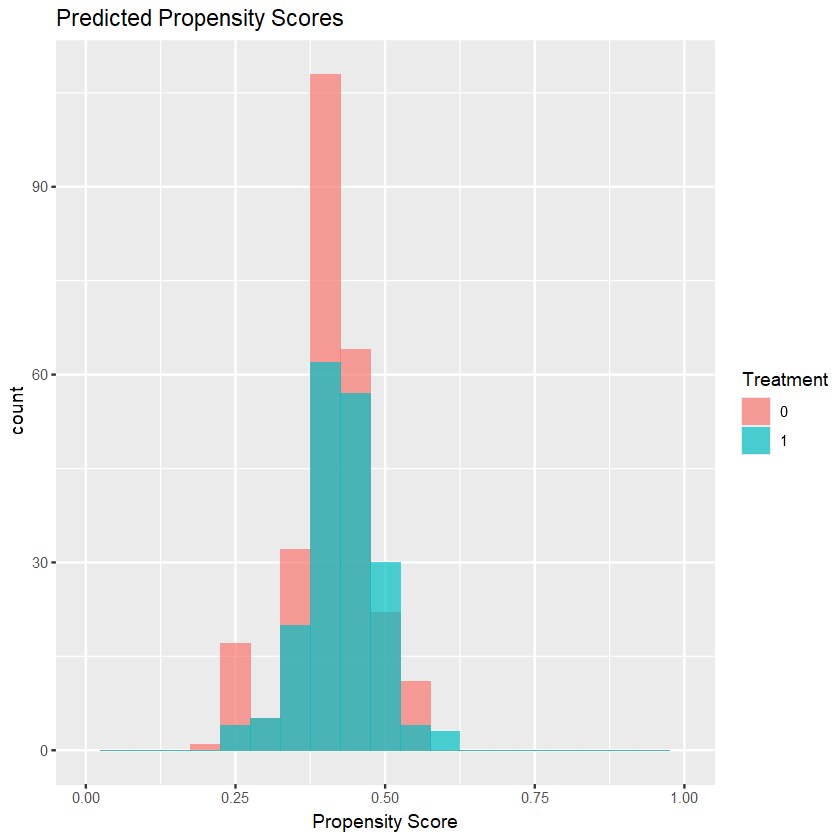

In [179]:

logistic_model <- glm(treat ~ age + educ + black_1 + hisp_1 + marr_1, 
                      data = data_dummy, 
                      family = binomial)

data_dummy$pscore <- predict(logistic_model, data_dummy, type = "response")

ggplot(data_dummy, aes(x = pscore, fill = as.factor(treat))) +
  geom_histogram(binwidth = 0.05, position = "identity", alpha = 0.7) +
  labs(
    title = "Predicted Propensity Scores",
    x = "Propensity Score",
    fill = "Treatment"
  ) +
  xlim(0, 1)


In [180]:
W <- data_dummy$treat
Y <- data_dummy$re78

In [181]:
tree_model <- causal_forest(X, Y, W, num.trees = 1, mtry = ncol(X), min.node.size = 20)

tree_structure <- get_tree(tree_model, 1)
print(tree_structure)

GRF tree object 
Number of training samples: 222 
Variable splits: 
(1) split_variable: age  split_value: 22 
  (2) * num_samples: 40  avg_Y: 5523.98 avg_W: 0.35 
  (3) * num_samples: 71  avg_Y: 5751.7 avg_W: 0.48 


Interpretación:

1.4. **Heterogeneous effects with causal forests (3 points)**. Use causal forests like we saw in class. For Python, you should use the econml package; for R, use the grf package; and for Julia, you will need to use the auxiliary variable 
Y
∗
 computed in the previous exercise and fit a random forest regressor. Report the importance of the prediction variables

In [195]:
forest_model <- causal_forest(X, Y, W, 
                              num.trees = 1000,  
                              mtry = ncol(X),    
                              min.node.size = 20)
tree <- get_tree(forest_model,1)
tree

GRF tree object 
Number of training samples: 222 
Variable splits: 
(1) split_variable: age  split_value: 24 
  (2) * num_samples: 55  avg_Y: 4849.58 avg_W: 0.38 
  (3) * num_samples: 56  avg_Y: 5137.78 avg_W: 0.36 

In [196]:
varimp <- variable_importance(forest_model)

ranked.vars <- order(varimp, decreasing = TRUE)

importances <- data.frame(
  variable = colnames(X)[ranked.vars],
  importance = varimp[ranked.vars]
)

print(importances)


    variable importance
1        age  0.4524639
2       educ  0.2499751
3    black_1  0.0000000
4     hisp_1  0.0000000
5     marr_1  0.0000000
6 nodegree_1  0.0000000


1.5. **Plot heterogeneous effects (1.5 points)**. Plot how the predicted treatment effect changes depending on a variable of your choice. (You can see the last example in PD11 for clarification of what you should do in this exercise)

In [185]:
data_dummy$age_bins <- round(data_dummy$age * 2) / 2


In [186]:
effects_bins <- aggregate(effects ~ age_bins, data = data_dummy, mean)

In [187]:
data_dummy$predicted_effects <- predict(cf)$predictions

predicted_effects_bins <- aggregate(predicted_effects ~ age_bins, data = data_dummy, mean)


In [188]:
# Escalar los efectos predichos al rango de los efectos reales
scale_factor <- mean(data_dummy$effects) / mean(data_dummy$predicted_effects)
data_dummy$predicted_effects_scaled <- data_dummy$predicted_effects * scale_factor


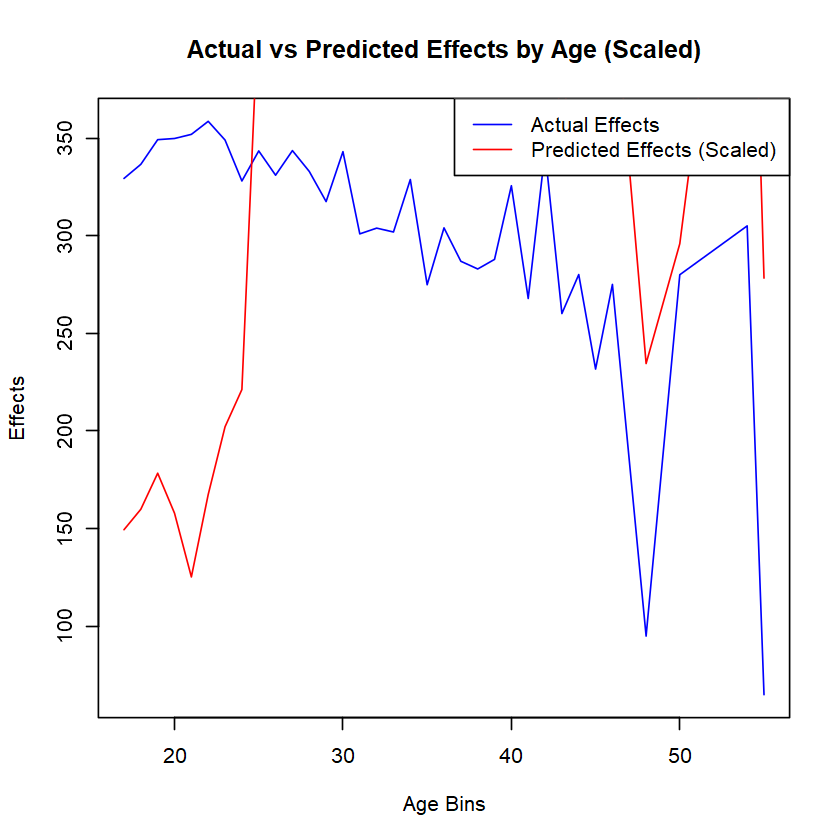

In [189]:
# Agrupar los efectos predichos escalados
predicted_effects_bins <- aggregate(predicted_effects_scaled ~ age_bins, data = data_dummy, mean)

# Graficar efectos reales vs. predichos escalados
plot(effects_bins$age_bins, effects_bins$effects, type = "l", col = "blue",
     xlab = "Age Bins", ylab = "Effects", main = "Actual vs Predicted Effects by Age (Scaled)")
lines(predicted_effects_bins$age_bins, predicted_effects_bins$predicted_effects_scaled, col = "red")
legend("topright", legend = c("Actual Effects", "Predicted Effects (Scaled)"), col = c("blue", "red"), lty = 1)


In [190]:
# Ver los primeros valores de cada agrupación
head(effects_bins)
head(predicted_effects_bins)

# Resumen estadístico de los efectos
summary(effects_bins$effects)
summary(predicted_effects_bins$predicted_effects)


,age_bins,effects
,<dbl>,<dbl>
1,17,329.3035
2,18,336.5385
3,19,349.1520
4,20,349.7553
5,21,351.8699
6,22,358.5390


,age_bins,predicted_effects_scaled
,<dbl>,<dbl>
1,17,149.4625
2,18,159.9459
3,19,178.3803
4,20,157.8926
5,21,125.2819
6,22,167.4895


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   65.0   280.8   311.2   298.9   341.4   358.5 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  125.3   245.5   436.2   392.4   507.4   619.7 